# Análisis de los estilos de escritura para identificación de la identidad

El objetivo es construir un modelo de usuario que representa su estilo de escritura. Dado que la data entregada es en esencia texto de reviews realizados no se requiere de información externa. De acuero a H.Gomez et al, 2019. la estilometria de escritura suele ser constante aún en expertos literatos. Es de suponerse, por lo tanto, que para el tipo de data y usuarios del problema la estilometría sea una efectiva técnica de identificación de identidad.

En este notebook presentamos el análisis de los resultados obtenidos una vez se construyeron los modelos de estilos de escritura para cada usuario. En este análisis se contemplaron 2 importantes variables para la construcción del modelo y su evaluación:

- El número de tokens (i.e. palabras+puntuación) requerido para la construcción del modelo de cada usuario. Queremos conocer el número adecuado de tokens para obtener un modelo preciso. Es de esperarse por supuesto que con menos tokens el modelo estilométrico sea menos preciso. Dado que los reviews son textos cortos no se cuenta con un corpus generoso de texto para modelar cada usuario, por lo que constituye una variable importante de análisis. Vamos a denotar esta variable **filter size**.

- La sesibilidad del modelo a la longitud del texto usado como entrada. La sensibilidad en nuestro caso hace referencia al número de tokens requerido como entrada a los modelos para evaluar con presición la identidad del usuario. En otras palabras cuanto es la longitud apropiada de un review nuevo para identificar con buena presición su identidad. Vamos a denotar esta variable **min_comment_size**.

Para hacer una prueba de concepto de este enfoque usamos el 10% de los usuarios del dataset. Todos los resultados presentados en este notebook son contemplando solo este 10% de los usuario.  Dado el volumen de la data esta muestra es claramente significativa. Una vez validada la prueba de concepto se valido con el dataset completo, pero dichos resultados son mostrados en el documento principal.

### Filtrando usuarios y construyendo datasets de entrenamiento y pruebas

El primer paso fue filtrar los usuarios de acuerdo a la variable **filter_size**. Usando el script **poner_nombre** creamos datasets con los usuarios con al menos 50, 30 y 10 reviews en el dataset. Se dividio de forma aleatoria el dataset en entrenamiento y pruebas usando una relación del 50% de los reviews. Los archivos resultantes son:

- UserFilter10-Testing-Random3.json ()
- UserFilter10-Training-Random3.json ()
- UserFilter30-Testing-Random3.json  ()
- UserFilter30-Training-Random3.json ()
- UserFilter50-Testing-Random3.json  ()
- UserFilter50-Training-Random3.json  ()

### Procesamiento

El objetivo es construir una representación vectorial del texto que permita la aplicación de modelos supervisados y no supervisados. De hecho de la experimentación realizada es claro que la selección de la representación vectorial es la clave para la identificación exitosa de la identidad de un usuario. El procesamiento se realizo usando el script "ModelsScriptLinuxServer.py".

1. Tokenización: Dada la longitud corta de los reviews se uso el TweetTokenizer del paquete nltk preservando por supuesto signos de puntuación y stop words.
2. Vectorización: Se crea un vector donde cada dimensión representa una palabra y el valor su frecuencia.
3. Etiquetas POS de cada palabra. 
4. Sobre las etiquetas POS construimos skipgrams de 2 posiciones.
5. Tal como lo establece H.Gomez et al., M. Pol et al. y Quian et al., la frecuencia de uso de palabras comunmente denomiadas como stop words (articulos, pronombres, advervios, pronombres e interjección) y signos de puntuación determinan en gran medida el estilo de escritura de una persona. Por esta razón del vector construido en 2 se eliminaron todas las dimensiones que no corresponden a las anteriores mencionadas.
6. El estilo tambien esta determinado  por la diversidad lexica utilizada. Los skipgrams generados en el paso 4 y su frecuencia fueron añadidos como dimensiones adicionales al vector producido en 5.
7. Se transformo la frecuencia asociado a cada dimension del vector por su z-score. Es decir se sustrajo la media y dividio por la desviación estandar ambas calculadas sobre todos los usuarios.  Por lo tanto cada dimension representa que tanto la palabra/signo puntucación/skipgram es usada en relación al usuario promedio.  

### Modelamiento

Se crearon dos modelos:
1. No supervisado: Calcula la similitud coseno entre el vector que representa a el usuario previamente construido y el vector producido por un nuevo comentario. Este modelo requiere que se defina un umbral para el valor coseno obtenido, de tal forma que para valores mayores a dicho umbral sea una match positivo de identidad. Para definir el umbral se construyeron las PDF (funciones de densidad de probabilidad) y se calculo el umbral para diferentes valores de significación sobre la hipotesis nula (i.e. que no exista mathc con un usuario).
2. Utilizando el vector de usuario como entrada se construyo una red neuronal LSTM (Long Short Term Memory) tal como se diseño en Quian et al. Esta red neuronal uensambla un clasificador SoftMax para predecir la existencia de match de identidad con un usuario X o no.



### Evaluación

Como se menciono anteriormente se dividieron los reviews de los usarios en testing y training. Se construyo para cada usuario en el dataset un review de longitud **min_comment_size** a partir de los reviews existentes. Como se menciono anteriormente **min_comment_size** es un parámetro para evaluar que tan sesible son los modelos a la longitud del texto que es usado como entrada. El review construido constituye un caso positivo de identidad que debería ser identificado por los modelos. Para hacer rigurosa la evaluación, para cada usuario del dataset tambien se construyo este review y se etiqueto como un caso negativo de identidad. En resumen para cada uno de los **n** usuarios en el dataset de testing existe un caso positivo (identidad corresponde) y **n-1** casos negativos (identidad no corresponde). Como valores de **min_comment_size** usamos [10, 50, 100, 300, 500, 1000]. El mínimo valor de longitud de texto es 10 tokens y el máximo 1000, que corresponden a los limites usuales en redes sociales y sistemas de reviews.

La lista de archivos de dataset de testing utilizados (notese que el número final en el nombre del archivo indica el valor de **min_comment_size** (estos archivos pueden ser generados usando "ModelsScriptLinuxServer.py"):

- UserFilter10-Testing-Random3-processing-{min_comment_size} (https://www.dropbox.com/s/n6snq0zcd2kdjni/UserFilter10-TestingDatasets.tar?dl=0)
- UserFilter30-Testing-Random3-processing-{min_comment_size} (https://www.dropbox.com/s/37vkzgeqvgzy30g/UserFilter30-TestingDatasets.tar?dl=0)
- UserFilter50-Testing-Random3-processing-{min_comment_size} (https://www.dropbox.com/s/5156c8bg9rd0elf/UserFilter50-TestingDatasets.tar?dl=0)

Para el modelo no supervisado se genero la matrix de similitudes coseno (ver ModelsScriptLinuxServer.py), que sigen la misma nomenclatura de nombre presentada anteriormente. 


Adicionalmente se contruyeron ejemplos negativos de la misma longitud

**A continuación se realiza el análisis de los resultados obtenidos**

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import nltk
import csv
import random
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.util import skipgrams
from scipy.cluster import hierarchy
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

## Análisis para un filter size de 50
Usuarios con al menos 50 reviews en el dataset (50% usado para testing, 50% usado para training)

In [2]:
filename_testing = "UserFilter50-Testing-Random3"
min_comment_size = 1000 # Dejamos el mas alto para este análisis inivial

In [3]:
dfsimi = pd.read_pickle(filename_testing+"-similarities"+str(min_comment_size))
print(dfsimi.shape)
#dfsimi.head()

(503, 503)


In [4]:
def matchesandnomatches(dfsimi):
    matches = np.diag(dfsimi)
    dfsimi_cop = dfsimi.copy()
    copy = pd.DataFrame(
        np.where(np.equal(*np.indices(dfsimi_cop.shape)), np.nan, dfsimi_cop.values),
        dfsimi_cop.index, dfsimi_cop.columns
    ).to_numpy().flatten()
    non_matches = copy[~np.isnan(copy)]
    return matches, non_matches

In [5]:
matches, non_matches = matchesandnomatches(dfsimi)

**Se cargo la matriz de similitud resultante y se grafíca la función de densidad de probabilidad de los valores de similitud coseno cuando la identidad corresponde y cuando la identidad no-corresponde.**


In [6]:
def plotpdf(matches, non_matches):    
    x = np.arange(-1,1,0.15)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, norm.pdf(x, np.mean(non_matches), np.std(non_matches)), label='Identidad no-corresponde', color='tab:blue')
    ax.fill_between(x, 0, norm.pdf(x, np.mean(non_matches), np.std(non_matches)), alpha=0.5, color='tab:blue')
    ax.plot(x, norm.pdf(x, np.mean(matches), np.std(matches)), label='Identidad corresponde', color='tab:green')
    ax.fill_between(x, 0, norm.pdf(x, np.mean(matches), np.std(matches)), alpha=0.5, color='tab:green')
    ax.set_title('Probability Density Functions')
    ax.set_xlabel('Valores de Similitud Coseno')
    ax.legend()

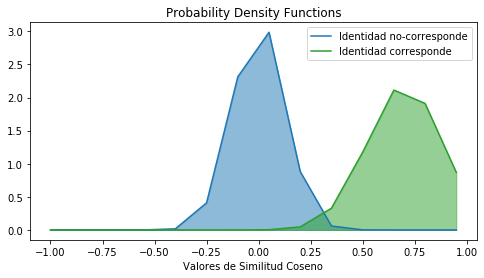

In [7]:
plotpdf(matches, non_matches)

Como se observa en la imagen un modelo basado en la similitud coseno parece apropiado (al menos para los valores de vairables filter_size y min_comment_size seleccionados). Cuando la identidad no corresponde se tienen valores pequeños de similitud, por el contrario cuando la identidad corresponde se tienen valores altos de similitud. En la siguientes lineas vamos a calcular el valor umbral de valor coseno para definir que una identidad corresponde cosiderando un valor de significacia "alpha=0.01".

In [8]:
alpha_nh = 0.01 # 1% significance level
cosine_threshold = norm.ppf(1-alpha_nh) * np.std(non_matches) - np.mean(non_matches)
print("Cosine Threshold: ",cosine_threshold)

Cosine Threshold:  0.28625588211127234


Utilizando este threshold se calcula la Presición, Recall y Accuracy.

In [9]:
def evaluation_metrics(matches,non_matches,cosine_threshold):
    TP = np.sum(matches > cosine_threshold) / len(matches) #same user predicted correctly
    FP = np.sum(non_matches >= cosine_threshold) / len(non_matches)
    FN = np.sum(matches <= cosine_threshold) / len(matches) #different user predicted incorrectly
    TN = np.sum(non_matches < cosine_threshold) / len(non_matches)

    P = TP/(TP+FP) #Precision (+)
    R = TP/(TP+FN) #Recall (+)
    A = (TP+TN)/(TP+FP+FN+TN) #Accuracy
    print("Precision (+): {}, Recall (+): {}, Accuracy {}".format(P,R,A))
    return P,R,A
    

In [10]:
evaluation_metrics(matches,non_matches,cosine_threshold)

Precision (+): 0.9809603139199331, Recall (+): 0.9840954274353877, Accuracy 0.9824974456052529


(0.9809603139199331, 0.9840954274353877, 0.9824974456052529)

**Efecto del filter size**

Ahora queremos conocer el efecto de disminuir el número de reviews usados para crear el modelo del usuario. El número de usuarios con mas de 50 reviews solo constituye el 0.85% de usuarios en el dataset, al disminuir el filter size a 30 y 10 estamos incluyendo el 4% y el 78% respectivamente.

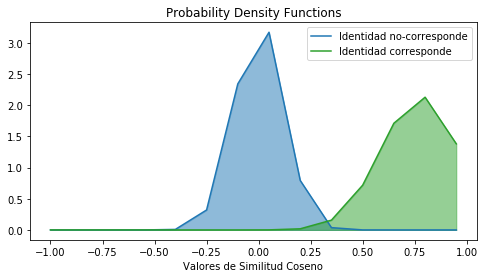

In [11]:
filename_testing_30 = "UserFilter30-Testing-Random3"
dfsimi_30 = pd.read_pickle(filename_testing_30+"-similarities"+str(min_comment_size))
matches_30, non_matches_30 = matchesandnomatches(dfsimi_30)
plotpdf(matches_30, non_matches_30)

In [12]:
cosine_threshold = norm.ppf(1-alpha_nh) * np.std(non_matches_30) - np.mean(non_matches_30)
print("Cosine Threshold: ",cosine_threshold)
evaluation_metrics(matches_30,non_matches_30,cosine_threshold)

Cosine Threshold:  0.26665653474410045
Precision (+): 0.9803812107015164, Recall (+): 0.9890329012961117, Accuracy 0.9846204898279214


(0.9803812107015164, 0.9890329012961117, 0.9846204898279214)

La metricas de evaluación se mantienen usando un filter_size de 30. Ahora vamos con un valor de 10.

In [13]:
filename_testing_10 = "UserFilter10-Testing-Random3"
dfsimi_10 = pd.read_pickle(filename_testing_10+"-similarities"+str(min_comment_size))
matches_10, non_matches_10 = matchesandnomatches(dfsimi_10)

Cosine Threshold:  0.2396776360916804
Precision (+): 0.9784326400686537, Recall (+): 0.9851990827600584, Accuracy 0.9817412858641321


(0.9784326400686537, 0.9851990827600584, 0.9817412858641321)

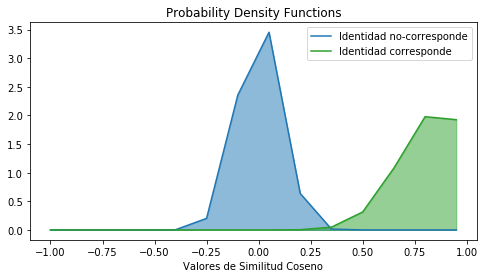

In [14]:
plotpdf(matches_10, non_matches_10)
cosine_threshold = norm.ppf(1-alpha_nh) * np.std(non_matches_10) - np.mean(non_matches_10)
print("Cosine Threshold: ",cosine_threshold)
evaluation_metrics(matches_10,non_matches_10,cosine_threshold)

La presición baja solamente un punto porcentual contemplando usuarios con almenos 10 reviews. Lo anterior demuestra que es posible construir un modelo de usuario robusto a partir del análisis del estilo de escritura.

## Análisis de la variable min_comment_size

Ahora que ya se cuenta con un modelo de usuario vamos a evaluar el efecto del tamaño de comentario de entrada para hacer la predicción correcta de la identidad. En los ejemplos anteriores usamos un min_comment_size de 1000 tokens, que en la practica es un review por encima de la media (~251 tokens). Vamos a evaluar entonces el efecto de min_comment_sie para valores de [10, 50, 100, 300, 500] utilizando un filter-size de 30.

In [15]:
filename_testing_30 = "UserFilter30-Testing-Random3"
min_comment_size = [10, 50, 100, 300, 500]
pre = []
reca = []
accu= []
for imin in min_comment_size:
    print("min_comment_size: ", imin)
    dfsimi_30 = pd.read_pickle(filename_testing_30+"-similarities"+str(imin))
    matches_30, non_matches_30 = matchesandnomatches(dfsimi_30)
    cosine_threshold = norm.ppf(1-alpha_nh) * np.std(non_matches_30) - np.mean(non_matches_30)
    P, R, A = evaluation_metrics(matches_30,non_matches_30,cosine_threshold)
    pre.append(P)
    reca.append(R)
    accu.append(A)  

min_comment_size:  10
Precision (+): 0.9756996784904866, Recall (+): 0.7367896311066799, Accuracy 0.8592197459517654
min_comment_size:  50
Precision (+): 0.97677220088921, Recall (+): 0.769690927218345, Accuracy 0.8756937769525754
min_comment_size:  100
Precision (+): 0.9782524469699753, Recall (+): 0.8215353938185443, Accuracy 0.9016359106313794
min_comment_size:  300
Precision (+): 0.9801219368738759, Recall (+): 0.9202392821535393, Accuracy 0.9507878559928995
min_comment_size:  500
Precision (+): 0.9804544622332526, Recall (+): 0.959122632103689, Accuracy 0.9700011741223435


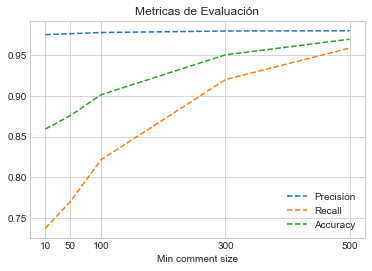

In [16]:
plt.style.use('seaborn-whitegrid')
plt.plot(min_comment_size,pre, linestyle='dashed', label='Precisión')
plt.plot(min_comment_size,reca, linestyle='dashed', label='Recall')
plt.plot(min_comment_size,accu, linestyle='dashed', label='Accuracy')
plt.xticks(min_comment_size, min_comment_size)
plt.title('Metricas de Evaluación')
plt.xlabel('Min comment size')
plt.legend()

Como se observa en la figura anterior se evidencia una perdida de ~12% en accuracy de nuestro modelo al reducirlo el tamaño del review de entrada a solo 10 tokens. Mas importante se reduce significativamente el recall (~22%) y muchos de los usuarios cuya identidad corresponde (son el mismo usuario) no son identificados. Como se esperaba la presición se mantiene constante ya que nuestra hipotesis nula sobre la cual se calculo el umbral del coseno es que el usuario no es un match, por lo tanto estamos priorizando los TP (true positive) a costa de FN (false negative).